In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
from torch import optim
from barbar import Bar
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import pickle
from NN import network,LeNet
import pandas as pd
import numpy as np
import pylab 
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from IPython import display

# DEEP SVDD For Multivariate

In [2]:
display.Image("./load.jpeg")

FileNotFoundError: No such file or directory: './load.jpeg'

FileNotFoundError: No such file or directory: './load.jpeg'

<IPython.core.display.Image object>

In [3]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1 and classname != 'Conv':
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("Linear") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)


def global_contrast_normalization(x):
    mean = torch.mean(x)
    x -= mean
    x_scale = torch.mean(torch.abs(x))
    x /= x_scale
    return x

In [4]:
class MNIST_loader(data.Dataset):
    def __init__(self, data, target, transform):
        self.data = data
        self.target = target
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        if self.transform:
            x = Image.fromarray(x.numpy(), mode='L')
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.data)

def get_mnist_after(args, training_data, training_label, testing_data, testing_label):
    min_max = [(-0.8826567065619495, 9.001545489292527),
                (-0.6661464580883915, 20.108062262467364),
                (-0.7820454743183202, 11.665100841080346),
                (-0.7645772083211267, 12.895051191467457),
                (-0.7253923114302238, 12.683235701611533),
                (-0.7698501867861425, 13.103278415430502),
                (-0.778418217980696, 10.457837397569108),
                (-0.7129780970522351, 12.057777597673047),
                (-0.8280402650205075, 10.581538445782988),
                (-0.7369959242164307, 10.697039838804978)]

    transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize([min_max[args.normal_class][0]],
                                                        [min_max[args.normal_class][1] \
                                                        -min_max[args.normal_class][0]])])
    data_train = MNIST_loader(training_data, training_label, transform)
    dataloader_train = DataLoader(data_train, batch_size=args.batch_size, 
                                shuffle=True, num_workers=0)
    data_test = MNIST_loader(testing_data, testing_label, transform)
    dataloader_test = DataLoader(data_test, batch_size=args.batch_size, 
                                shuffle=True, num_workers=0)
    return dataloader_train, dataloader_test

In [5]:
class DeepSvdd:
    def __init__(self, args, data, device):
        self.args = args
        self.train_loader, self.test_loader = data
        self.device = device
    

    def pretrain(self):
        ae = LeNet(self.args.latent_dim).to(self.device)
        ae.apply(weights_init_normal)
        optimizer = optim.Adam(ae.parameters(), lr=self.args.lr_ae,
                               weight_decay=self.args.weight_decay_ae)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                    milestones=self.args.lr_milestones, gamma=0.1)
        
        ae.train()
        for epoch in tqdm(range(self.args.num_epochs_ae)):
            total_loss = 0
            #HerePlease
            for x, _ in (self.train_loader):
                x = x.float().to(self.device)
                
                optimizer.zero_grad()
                x_hat = ae(x)
                reconst_loss = torch.mean(torch.sum((x_hat - x) ** 2, dim=tuple(range(1, x_hat.dim()))))
                
                reconst_loss.backward()
                optimizer.step()
                
                total_loss += reconst_loss.item()
            scheduler.step()
            '''print('Pretraining Autoencoder... Epoch: {}, Loss: {:.3f}'.format(
                   epoch, total_loss/len(self.train_loader)))'''
        self.save_weights_for_DeepSVDD(ae, self.train_loader) 
    

    def save_weights_for_DeepSVDD(self, model, dataloader):
        c = self.set_c(model, dataloader)
        net = network(self.args.latent_dim).to(self.device)
        state_dict = model.state_dict()
        net.load_state_dict(state_dict, strict=False)
        torch.save({'center': c.cpu().data.numpy().tolist(),
                    'net_dict': net.state_dict()}, './pretrained_parameters.pth')
    

    def set_c(self, model, dataloader, eps=0.1):
        model.eval()
        z_ = []
        with torch.no_grad():
            for x, _ in dataloader:
                x = x.float().to(self.device)
                z = model.place_net(x)
                z_.append(z.detach())
        z_ = torch.cat(z_)
        c = torch.mean(z_, dim=0)
        c[(abs(c) < eps) & (c < 0)] = -eps
        c[(abs(c) < eps) & (c > 0)] = eps
        return c


    def train(self):
        net = network().to(self.device)
        
        if self.args.pretrain==True:
            state_dict = torch.load('./pretrained_parameters.pth')
            net.load_state_dict(state_dict['net_dict'])
            c = torch.Tensor(state_dict['center']).to(self.device)
        else:
            net.apply(weights_init_normal)
            c = torch.randn(self.args.latent_dim).to(self.device)
        
        optimizer = optim.Adam(net.parameters(), lr=self.args.lr,
                               weight_decay=self.args.weight_decay)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                    milestones=self.args.lr_milestones, gamma=0.1)

        net.train()
        for epoch in tqdm(range(self.args.num_epochs)):
            total_loss = 0
            for x, _ in (self.train_loader):
                x = x.float().to(self.device)

                optimizer.zero_grad()
                z = net(x)
                loss = torch.mean(torch.sum((z - c) ** 2, dim=1))
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
            scheduler.step()
            '''print('Training Deep SVDD... Epoch: {}, Loss: {:.3f}'.format(
                   epoch, total_loss/len(self.train_loader)))'''
        self.net = net
        self.c = c

In [6]:
def eval(net, c, dataloader, device):
    scores = []
    labels = []
    net.eval()
    #print('Testing...')
    with torch.no_grad():
        for x, y in dataloader:
            x = x.float().to(device)
            z = net(x)
            score = torch.sum((z - c) ** 2, dim=1)

            scores.append(score.detach().cpu())
            labels.append(y.cpu())
    labels, scores = torch.cat(labels).numpy(), torch.cat(scores).numpy()
    #print('ROC AUC score: {:.2f}'.format(roc_auc_score(labels, scores)*100))
    return labels, scores

In [7]:
class Args:
    def __init__(self, nclass):
        self.num_epochs=20
        self.num_epochs_ae=20
        self.patience=50
        self.lr=1e-4
        self.weight_decay=0.5e-6
        self.weight_decay_ae=0.5e-3
        self.lr_ae=1e-4
        self.lr_milestones=[50]
        self.batch_size=200
        self.pretrain=True
        self.latent_dim=32
        self.normal_class=nclass

In [8]:
with open('./Dataset_pickel/X_train.pickle', 'rb') as f:
    training_data= pickle.load(f)
with open('./Dataset_pickel/y_train.pickle', 'rb') as f:
    training_label= pickle.load(f)
with open('./Dataset_pickel/X_test.pickle', 'rb') as f:
    testing_data= pickle.load(f)
with open('./Dataset_pickel/y_test.pickle', 'rb') as f:
    testing_label= pickle.load(f)

In [9]:
N_classes=2

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
nscores=[]
inscores=[]
outscores=[] 
for i in range(N_classes):
    print("Class ",i)
    args = Args(i)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data = get_mnist_after(args, training_data, training_label, testing_data, testing_label)
    deep_SVDD = DeepSvdd(args, data, device)
    if args.pretrain:
        deep_SVDD.pretrain()
    deep_SVDD.train()
    '''print("test for class  ",i,".....")'''
    labels, scores = eval(deep_SVDD.net, deep_SVDD.c, data[1], device)
    nscores.append(roc_auc_score(labels, scores)*100)
    inscores.append(scores[np.where(labels==0)[0]])
    outscores.append(scores[np.where(labels==1)[0]])

Class  0


  0%|          | 0/20 [00:00<?, ?it/s]

Class  1


100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


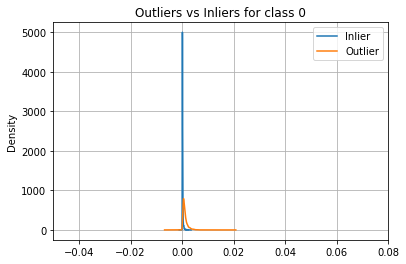

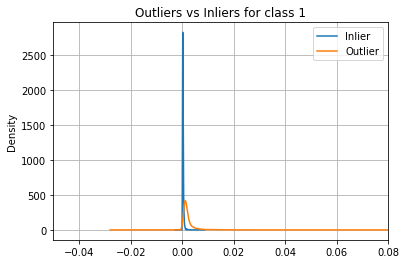

In [11]:
import matplotlib.pyplot as plt
import pandas as pd 
for i in range(N_classes):
    in_ = pd.DataFrame(inscores[i], columns=['Inlier'])
    out_ = pd.DataFrame(outscores[i], columns=['Outlier'])
    fig, ax = plt.subplots()
    in_.plot.kde(ax=ax, legend=True, title='Outliers vs Inliers for class '+str(i))
    out_.plot.kde(ax=ax, legend=True)
    plt.xlim(-0.05, 0.08)
    ax.grid(axis='x')
    ax.grid(axis='y')
    plt.show()